# **About:**
This notebook is used to finetune a pre-trained language model with a custom dataset. It contains code and instructions to generate your custom dataset and use that dataset to finetune the model. 

The code in this notebook has been tested on the following models:
*   sshleifer/distilbart-cnn-12-6 (longer, extractive summaries)
*   sshleifer/distilbart-xsum-12-6 (shorter, 'intelligent' summaries)

As per the example documentation, this code will work on any language model that uses any of the following architecture: 
* BartForConditionalGeneration (and anything that inherits from it)
* MarianMTModel
* PegasusForConditionalGeneration
* MBartForConditionalGeneration
* FSMTForConditionalGeneration
* T5ForConditionalGeneration

***Note: You must replace all file paths with your own when running these examples. This code takes advantage of the unlimited storage with a Organization Google Drive account, so my models are stored in my drive. These language models are large, so store them locally at your own risk.***




# **Import Statements:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/CS196Project/Group6/finetuning"

!pip install pyarrow==2.0.0
!pip install -r requirements.txt

import re
import torch
from datasets import load_dataset

Get all required code for finetuning. These python files are used to finetune a pre-trained distilbart language model. All code has been taken and adapted from [examples](https://github.com/huggingface/transformers/tree/master/examples/seq2seq) in the transformers library.


In [ ]:
%%bash
cd "/content/drive/My Drive/CS196Project/Group6/finetuning/seq2seq"

# These files are already stored in our GitHub Repo

# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/finetune.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/callbacks.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/utils.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/sentence_splitter.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/lightning_base.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/requirements.txt

# **Create Custom Dataset:**

This code will take test files split as explained below and convert them into the correct format required by the examples in the transformers library.

The text files can be located anywhere as long as you provide the correct paths to those files later in this code.

The 

The text files must be formatted as follows:

[TEXT]

blah blah blah

...

blah blah blah

[SUMM]

blah blah 

blah blah

[TEXT]
...


In [1]:
class CreateDataset:
  """
  This is a class to convert text files as formatted above into the required format.

  Attributes:
    source_lengths (List): a list of the word counts of all text data entries
    target_lengths (List): a list of the word counts of all the summary data entries

  Important Note:
  ** All variables and functions that begin with '_' are private and must not be modified/called
  ** They are used to keep track of entries and the correct file to add them to
  """
  
  def __init__(self, folder_path: str, split_ratio=(2, 1, 1)):
    """
    The constructor used to initialize the dataset creator.

    Parameters:
      folder_path (str): the desired folder/path to store the final training/testing/validation data files
      split_ratio (Tuple) [Optional]: the ratio of training data examples to testing data examples and validation examples
        - formatted as follows: split_ratio = (train, test, val)
        - defaults to (2, 1, 1) or 50% of the original data goes to training, 25% each to testing and validation
    """
    assert len(split_ratio) == 3
    assert type(split_ratio) == tuple

    assert type(folder_path) == str
    assert folder_path != None and len(folder_path) > 0

    if folder_path[:-1] != "/":
      folder_path += "/"

    # Use the split ratios to create benchmark incides
    self._iter_counter = 0
    self._split_counter = 0
    self._train_cut = split_ratio[0]
    self._test_cut = self.train_cut + split_ratio[1]
    self._val_cut = self.test_cut + split_ratio[2]

    # Create/open source and target text files to append to
    train_source = open("{}train.source".format(folder_path), "w+")
    train_target = open("{}train.target".format(folder_path), "w+")
    test_source = open("{}test.source".format(folder_path), "w+")
    test_target = open("{}test.target".format(folder_path), "w+")
    val_source = open("{}val.source".format(folder_path), "w+")
    val_target = open("{}val.target".format(folder_path), "w+")

    self._sources = [train_source, test_source, val_source]
    self._targets = [train_target, test_target, val_target]

    # Lists that store the final target and source word counts
    self.source_lengths = []
    self.target_lengths = []

  def create_data_files(self, data_path: str, finished=False) -> None:
    """
    This function used to get a text file, extract data, and write to the train/test/val files.
    
    Parameters: 
      data_path (str): the path to a text file formatted as explained above with text and summaries
      finished (bool) [Optional*]: whether to close the new train/test/val files when finished adding examples
        - proper practice would be to add finished=True for the last call of this function
    """

    assert type(data_path) == str
    assert data_path != None and len(data_path) > 0

    lines = self._get_prepared_lines(data_path)

    for example in lines:
      if not len(example):  # ignore any emtpy text
        continue
      
      source, target = self._next_entry()

      data = example.replace("[SEP]", "")
      text, summary = data.split("[SUMM]")

      # UPDATE: 
      # I am removing the code that removes captions to build up a bias against them 
      # in the language model. This will allow users to 'accidentally' copy and paste
      # captions and not having them reflected in the final summary output.

      # I am preserving the code here for future reference.
      # # remove any captions
      # # Do this after all other processing to preserve the [TEXT] and [SUMM] tags
      # text = re.sub(r'\[.*\]', '', text)
      # summary = re.sub(r'\[.*\]', '', summary)

      self.source_lengths.append(len(text.split(" ")))
      self.target_lengths.append(len(summary.split(" ")))

      # source.write("{}\n".format(text))
      # target.write("{}\n".format(summary))

    if finished:
      self._finish()  # close any opened text files we were appending to

  def _get_prepared_lines(self, data_path: str) -> list:
    """
    This function is a private function used to format text entries correctly.

    Parameters: 
      data_path (str): the path to a text file formatted as explained above with text and summaries
    """
    # IDEAS:
    # - replace '%' with 'percent'

    text_file = open(data_path, "r").read()
    text_file = text_file.replace("\n", " ")
    # strip text of all newlines, so we can control where they get places later on
    # newlines are used to separate entries in train/test/validation datasets

    text_file = text_file.replace("\t", " ")
    text_file = text_file.replace("-", " ")
    text_file = re.sub(r'\(.*\)', '', text_file)
    text_file = re.sub(r'[\u201d\u201c\u2018\u2019]+', '', text_file) # remove weird quotation marks
    
    text_file = re.sub(r' [ ]+', ' ', text_file)
    # Replace any sequences of 2+ spaces with a single space

    # text_file = re.sub(r'\.(?=[^ ])', '. ', text_file)
    # replace a period followed immediately with a character with a period and a space

    split_by_separation = text_file.split("[TEXT]")
    
    return split_by_separation

  def _finish(self) -> None:
    """
    This is a private function used to close all text files after appending to them.
    """
    for f in self.sources:
      f.close()
    
    for f in self.targets:
      f.close()
      
  def _next_entry(self) -> tuple:
    """
    This is a private function used to keep track of the number of entries per file and distribute data according to the defined split.
    """
    if self._iter_counter == self._val_cut:
      self._split_counter = 0
      self._iter_counter = 0
    elif self._iter_counter == self._train_cut or self._iter_counter == self._test_cut:
      self._split_counter += 1
      
    self._iter_counter += 1
    return self._sources[self._split_counter], self._targets[self._split_counter]

# **Create the Training, Testing, and Validation Text Files:**

These function calls use the code above to process the lecture transcripts into the correct format. The use and explanation of all parameters are within the docstrings of the functions and below: 
 
CreateDataset constructor:
```
The constructor used to initialize the dataset creator.

Parameters:
  folder_path (str): the desired folder/path to store the final training/testing/validation data files
  split_ratio (Tuple) [Optional]: the ratio of training data examples to testing data examples and validation examples
    - formatted as follows: split_ratio = (train, test, val)
    - defaults to (2, 1, 1) or 50% of the original data goes to training, 25% each to testing and validation
```
CreateDataset.create_data_files:
```
This function used to get a text file, extract data, and write to the train/test/val files.
    
Parameters: 
  data_path (str): the path to a text file formatted as explained above with text and summaries
  finished (bool) [Optional*]: whether to close the new train/test/val files when finished adding examples
    - proper practice would be to add finished=True for the last call of this function

```



In [ ]:
%cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"

dataset = CreateDataset("lecture_transcripts/")
dataset.create_data_files("transcripts_to_format/jonah_LectureDataset.txt")
dataset.create_data_files("transcripts_to_format/rohan_transcripts.txt")
dataset.create_data_files("transcripts_to_format/aadarsh_lecture_transcripts.txt")
dataset.create_data_files("transcripts_to_format/neilk3_lecture_training.txt", finished=True)

/content/drive/My Drive/CS196Project/Group6/finetuning


# **Lengths of Source and Target Entries:**

This will be used to refine the test set and perhaps shorten certain summaries to keep some consistency in length.

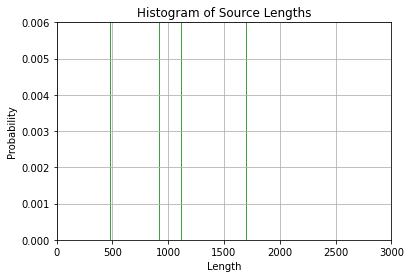

[3366, 920, 1427, 1120, 1702, 589, 481, 611, 995, 812]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(dataset.source_lengths, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Histogram of Source Lengths')
plt.xlim(0, 3000)
plt.ylim(0, 0.006)
plt.grid(True)
plt.show()
dataset.source_lengths

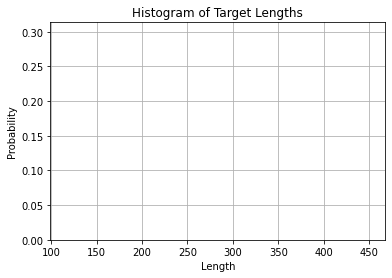

[451, 116, 223, 186, 273, 319, 362, 351, 443, 368]

In [ ]:
n, bins, patches = plt.hist(dataset.target_lengths, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Histogram of Target Lengths')
# plt.xlim(0, 3000)
# plt.ylim(0, 0.006)
plt.grid(True)
plt.show()
dataset.target_lengths

# **Load Huggingface or Other Large Datasets:**

 This section is a work in progress to finetune our language model on more large datasets. The goal is to filter the datasets for examples and summaries shorter than n and m words. 


In [ ]:
import pandas as pd

# newsroom = load_dataset('newsroom', data_dir='/content/drive/My Drive/CS196Project/newsroom')

# df = pd.read_json("/content/drive/My Drive/CS196Project/newsroom/dev.jsonl", lines=True)  # usecols=fields
# df = df[['text', 'summary', 'compression_bin', 'coverage_bin', 'density_bin']]

def filter_by_len(column: pd.Series, max_text_len=1024, max_summ_len=70) -> bool:
  text_len = len(column.text.split(" "))
  summ_len = len(column.summary.split(" "))
  return text_len <= max_text_len and summ_len <= max_summ_len

short = df[df.apply(filter_by_len, axis=1)]
shorter = short[short.apply(lambda x: filter_by_len(x, max_text_len=900), axis=1)]

print(df.shape, short.shape, shorter.shape)
print(shorter.groupby('density_bin').size())
shorter.head()

(108837, 5) (90596, 5) (84551, 5)
density_bin
abstractive    29218
extractive     27542
mixed          27791
dtype: int64


,text,summary,compression_bin,coverage_bin,density_bin
0,So sayeth Padre general manager Kevin Towers.\...,SAN DIEGO PADRES team notebook,high,medium,abstractive
3,Remember when everyone on Earth was glued to T...,Check out the chart to find out what the world...,low,medium,abstractive
4,"TEHRAN | Mon Jan 31, 2011 9:17am EST\n\nTEHRAN...",TEHRAN (Reuters) - An American woman who was f...,low,high,extractive
5,"By Maggie Fox, Health and Science Editor\n\nWA...",WASHINGTON (Reuters) - A vaccine designed to t...,medium,high,extractive
6,"Welcome back, Skipthusiasts! As many of you kn...",Get the inside story of life inside the White ...,medium,low,abstractive


# **Finetuning the Model:**

In [ ]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [ ]:
%%bash

cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"
pwd

# Unused Alternative Parameters:
    # --do_predict \
    # --eval_batch_size=1 \

    # --freeze_embeds \
    # --fp16 \
    #     --max_target_length=60 \
    # --val_max_target_length=60 \
    # --test_max_target_length=100 \

# --val_metric, type=str, default=None, required=False, choices=["bleu", "rouge2", "loss", None]

# MODEL="google/pegasus-xsum"

export OUTPUT_DIR="distilbart-cnn-12-6"
export DATA_DIR="lecture_transcripts"

python seq2seq/finetune.py \
    --learning_rate=3e-5 \
    --gpus 1 \
    --do_train \
    --do_predict \
    --n_val 1000 \
    --val_check_interval 0.1 \
    --data_dir=$DATA_DIR \
    --train_batch_size=1 \
    --eval_batch_size=1 \
    --max_target_length=60
    --output_dir=$OUTPUT_DIR \
    --overwrite_output_dir \
    --freeze_encoder \
    --num_train_epochs 6 \
    --model_name_or_path "sshleifer/distilbart-cnn-12-6"
    "$@"

# **Test the Finetuned Model:**

Showing that the fine-tuning has an effect: 

1.   Summarization with stored fine-tuned model
2.   Summarization with default model used

***You should have generated the language model by finetuning before running this code. It pulls from an assumed pretrained and finetuned model. Otherwise, you may comment out parts of the code and/or run other models.***



In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, pipeline

%cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"

device = 'cpu'
text = "DNA evidence has transformed forensic science and the criminal justice system. But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the basic structure of DNA and the rules of inheritance. Let’s start by simply defining a few terms, and we’ll start with the term heredity. Heredity can simply be defined as the passing of traits to offspring. We can think about this in 2 time scales—a short time scale over just 1 generation or a long time scale involving ancestors that go back millennia. Another term that we should define is phenotype. A measurable trait of an organism is often referred to as a phenotype. Here we list examples under different categories like disease or behavioral phenotypes. We can classify phenotypes into 2 types of traits: simple inherited traits and complex inherited traits.Traits of simple inheritance have the following characteristics: They are monogenic or controlled by only 1 gene. They are binary or discontinuous. And the expression of these traits is not greatly influenced by the environment. Simple inherited traits represent only a small fraction of all human traits."

# 1. Summarization with example fine-tuned model 
# model = AutoModelForSeq2SeqLM.from_pretrained(f'example_output/best_tfmr')
# tokenizer = AutoTokenizer.from_pretrained(f'example_output/best_tfmr')
# model = model.to(device)
# summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
# print(summarizer(text))

# 1.1 Summarization with finetuned distilbart-xsum-12-6
model = AutoModelForSeq2SeqLM.from_pretrained(f'distilbart-xsum-12-6/best_tfmr')
tokenizer = AutoTokenizer.from_pretrained(f'distilbart-xsum-12-6/best_tfmr')
model = model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

# 1.2 Summarization with finetuned distilbart-cnn-12-6
model = AutoModelForSeq2SeqLM.from_pretrained(f'distilbart-cnn-12-6/best_tfmr')
tokenizer = AutoTokenizer.from_pretrained(f'distilbart-cnn-12-6/best_tfmr')
model = model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

# 2. Summarization with default model used before finetuning
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6") 
model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

/content/drive/My Drive/CS196Project/Group6/finetuning
[{'summary_text': ' The use of DNA as a tool in forensic science has been hailed as a game-changer.'}]
[{'summary_text': ' DNA evidence has transformed forensic science and the criminal justice system. But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the basic structure of DNA and the rules of inheritance. Let’s start by simply defining a few terms, and we’ll start with the term heredity.'}]
[{'summary_text': ' DNA evidence has transformed forensic science and the criminal justice system . But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the structure of DNA and the rules of inheritance . We can classify phenotypes into 2 types of traits: simple inherited traits and complex inherited traits . Simple inherited traits represent only a small fraction of all human traits .'}]
